# Graph Based Segragation Index

Socio- Economic Data Retrived from:

http://www.ecuadorencifras.gob.ec/documentos/datos/Poblacion_y_Demografia/Censo_poblacion_y_vivienda_/bdd_nivel_manzana_censal/Spss/CPV2010M_SPSS_Azuay.zip

SPSS file processed in R. We use dwelling as our unit of analysis, all the data has been previously aggregated at this level

In [1]:
%load_ext autoreload
%autoreload 2
import multiplex_segregation as ms
from multiplex_segregation import np, pd, gpd, nx, ox
import glob
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import display, Markdown

## Configuration script

In [2]:
network_type = 'drive'                    #get walkable streets and paths (ignores directionality)
retain_all = False                       #retain all only largest connected component
crs_osm = {'init':'epsg:4326'}           #crs that osm uses
crs_utm = {'init':'epsg:32717'}          #crs that for the city of Cuenca in UTM
input_folder = 'input_data'              #the input urban areas shapefiles folder

urban_area = 'Sectores_EC.shp'
blocks = 'blocks.shp'                    #the input shapefile name for block geometry
busLine = 'bus_lines.shp'                #the input shapefile name for bus lines
busStop = 'bus_stops'                    #the input file for all bus stop shaspes
allFiles = glob.glob('{}/{}/*.shp'.format(input_folder, busStop)) #list of all bus stop shapes
tramLine = 'tram_lines.shp'              #the input shapefile name for tram lines
tramStop = 'tram_stops.shp'              #the input shapefile name for tram stops
icvIndex = 'blockICV.csv'    #the input csv for calculated ICV index

graphs_folder = 'output_data/graphs'     #output folder to save graphs
output_path = 'output_data'              #output folder to save the stats
output_img = 'output_data/img'           #output folder to save figures

### Read ShapeFiles and Reprojections

In [3]:
#import shapefile as geopandas dataframe
blocksGPD =  gpd.read_file('{}/{}'.format(input_folder, blocks))
busLineGPD = gpd.read_file('{}/{}'.format(input_folder, busLine))
tramLineGPD = gpd.read_file('{}/{}'.format(input_folder, tramLine))
tramStopGPD = gpd.read_file('{}/{}'.format(input_folder, tramStop))

busStop_list = []

for file_ in allFiles:
    lineNum = file_.split('linea_',1)[1].split('.')[0]
    df = gpd.read_file(file_)
    df['lineNum'] = int(lineNum)
    busStop_list.append(df)
busStopGPD = gpd.GeoDataFrame(pd.concat(busStop_list, ignore_index = True))

#import ICV index as pandas dataframe
icvIndexDf = pd.read_csv('{}/{}'.format(output_path, icvIndex), dtype = {
    'id_man': str,
    'Q1' : np.float64, 
    'Q2' : np.float64,
    'Q3' : np.float64,
    'Q4' : np.float64,
    'ICV': np.float64,
    'nDwelling' : np.int32, 
    'nPeople' : np.int32    
})

In [4]:
display(
    Markdown('**General Information**'),
    Markdown('&nbsp;&nbsp;&nbsp;&nbsp;Number of Blocks: ' + str(len(blocksGPD.index))),
    Markdown('&nbsp;&nbsp;&nbsp;&nbsp;Number of Blocks with ICV: ' + str(len(icvIndexDf))),
    Markdown('&nbsp;&nbsp;&nbsp;&nbsp;Number of Bus Lines: ' + str(len(busLineGPD.LINEA.unique()))),
    Markdown('&nbsp;&nbsp;&nbsp;&nbsp;Number of Bus Stops: ' + str(len(busStopGPD.index))),
    Markdown('&nbsp;&nbsp;&nbsp;&nbsp;Number of Tram Lines: ' + str(len(tramLineGPD.FID_.unique()))),
    Markdown('&nbsp;&nbsp;&nbsp;&nbsp;Number of Tram stops: ' + str(len(tramStopGPD.index)))
)

**General Information**

&nbsp;&nbsp;&nbsp;&nbsp;Number of Blocks: 3800

&nbsp;&nbsp;&nbsp;&nbsp;Number of Blocks with ICV: 3391

&nbsp;&nbsp;&nbsp;&nbsp;Number of Bus Lines: 29

&nbsp;&nbsp;&nbsp;&nbsp;Number of Bus Stops: 3037

&nbsp;&nbsp;&nbsp;&nbsp;Number of Tram Lines: 1

&nbsp;&nbsp;&nbsp;&nbsp;Number of Tram stops: 41

## Download street network

Blocks define urban area, alpha shape is used to draw a boundary around multiple unconnected block geometries

Calculating Boundary with alpha = 0.004 ...


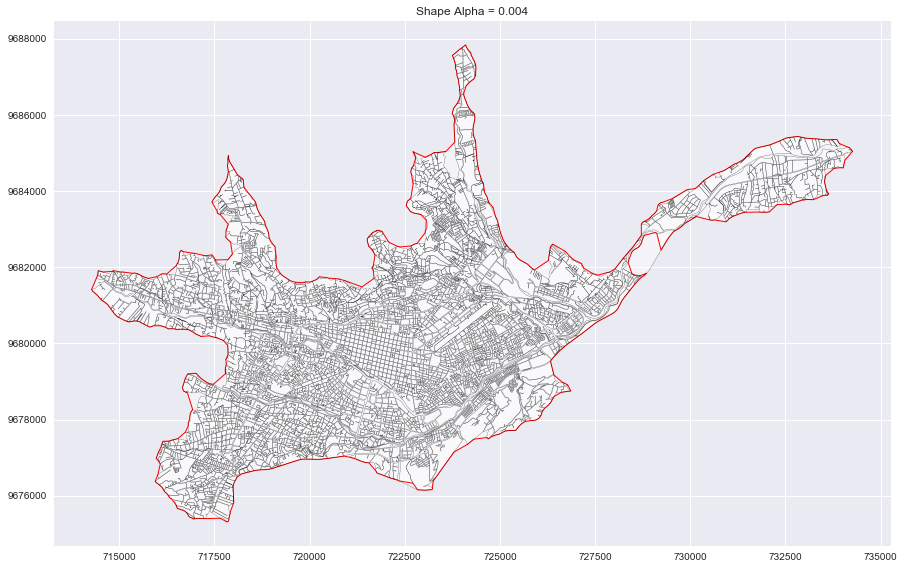

Calculating Boundary with alpha = 0.0035 ...


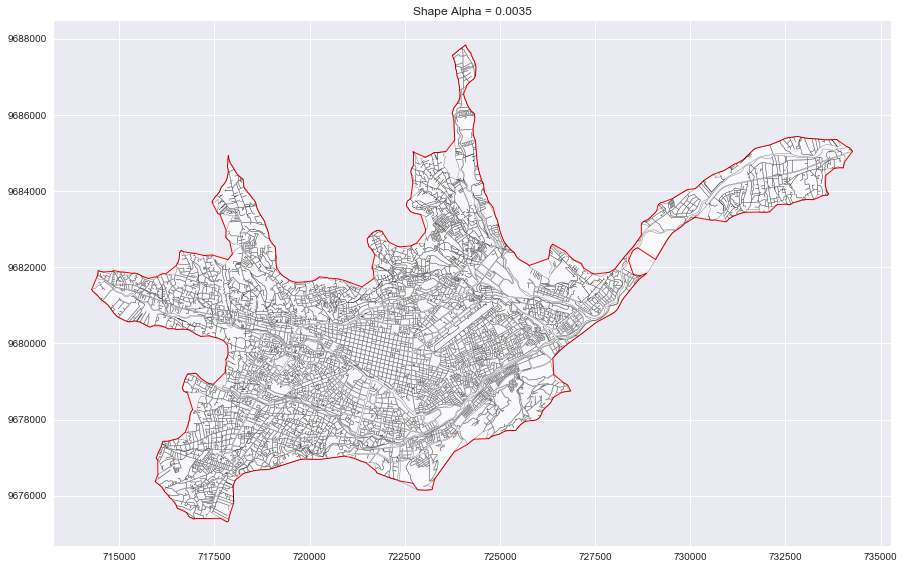

Calculating Boundary with alpha = 0.003 ...


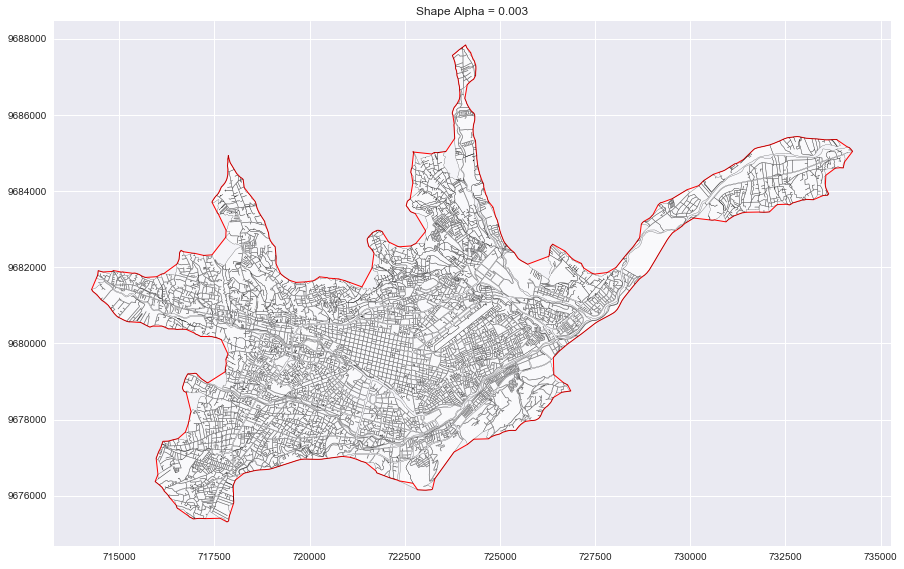

Calculating Boundary with alpha = 0.0025 ...


In [5]:
for i in range(4):
    alpha = 0.004 - (i*0.0005)
    temp = ms.boundary_from_areas(blocksGPD, alpha = alpha)
    base = temp.plot(color = 'white',edgecolor='red',linewidth=1, figsize = (15,10))
    base.set_title("Shape Alpha = {}".format(alpha))
    blocksGPD.plot(color = 'white',edgecolor='black',linewidth=0.2,  ax = base)
    plt.show()

## Create Street Network
create time weighted graph to represent the street network using Block Geometry, Alpha Value = 0.0025 and a walking speed = 5km/h

In [101]:
street_network, area = ms.construct_street_graph(blocksGPD,
                                                crs_osm, 
                                                crs_utm,
                                                alpha = 0.0025,
                                                buffer_dist=200,
                                                speed = 5
                                               )

Generating geometry...
Calculating Boundary with alpha = 0.0025 ...
Generating street graph...


C:\Anaconda\lib\site-packages\osmnx\utils.py:268: RuntimeWarning: invalid value encountered in arccos
  arc = np.arccos(cos)


Reprojecting street graph...
done!


In [7]:
#Save Road Network and Urban Area
print('Saving street graph and Urban Area')
ox.save_graph_shapefile(street_network, folder = graphs_folder, filename = '{}/shapefile'.format('street_network'))
ox.save_graphml(street_network, folder = graphs_folder, filename = '{}/graph'.format('street_network'))
area.to_file('{}/area'.format(output_path))

Saving street graph and Urban Area


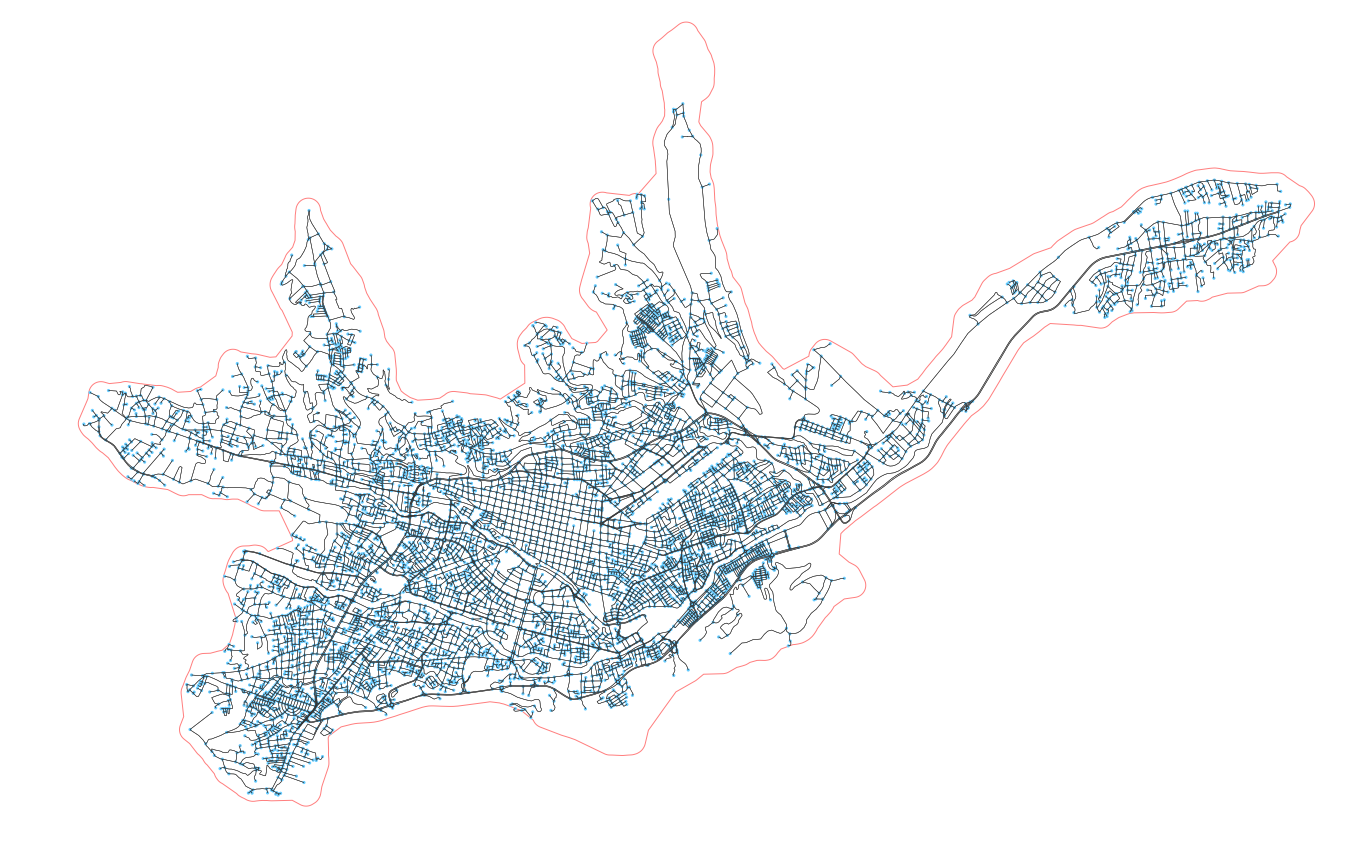

In [8]:
ms.plot_network(street_network, area)

## Get Road Network Stats

calculating shortest path betweenness...
calculating random walk betweenness...
calculating reaching centrality...
calculating information centrality...
generating plots...
calculating measures for: Betweenness Centrality


calculating measures for: Random Walk Betweenness


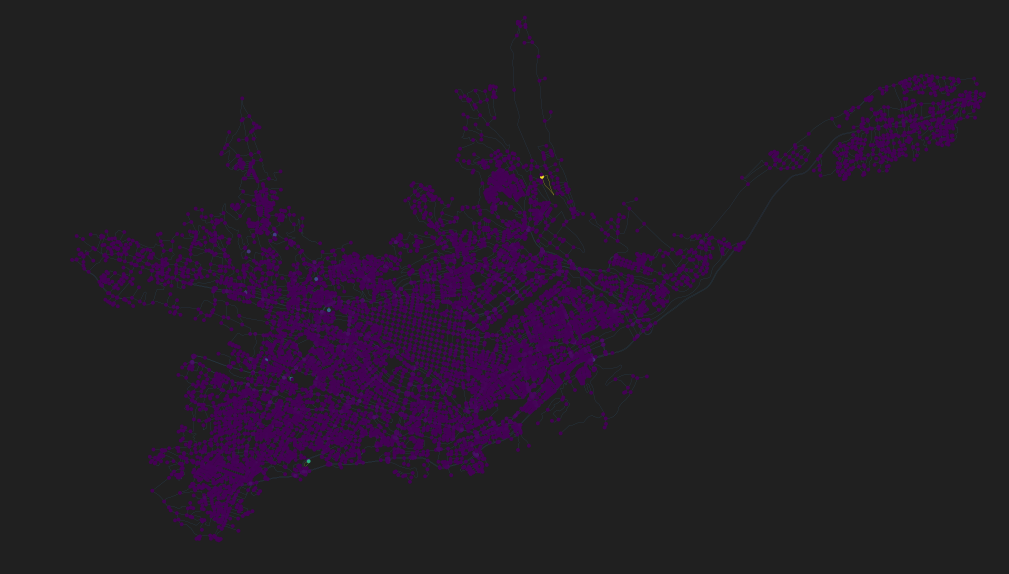

calculating measures for: Information Centrality


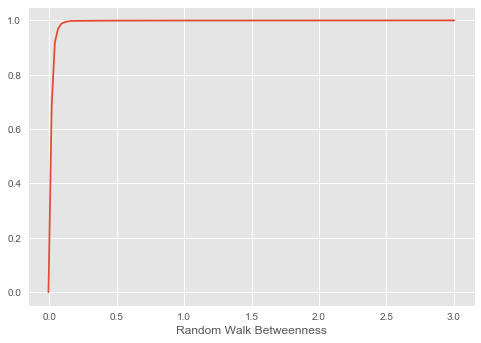

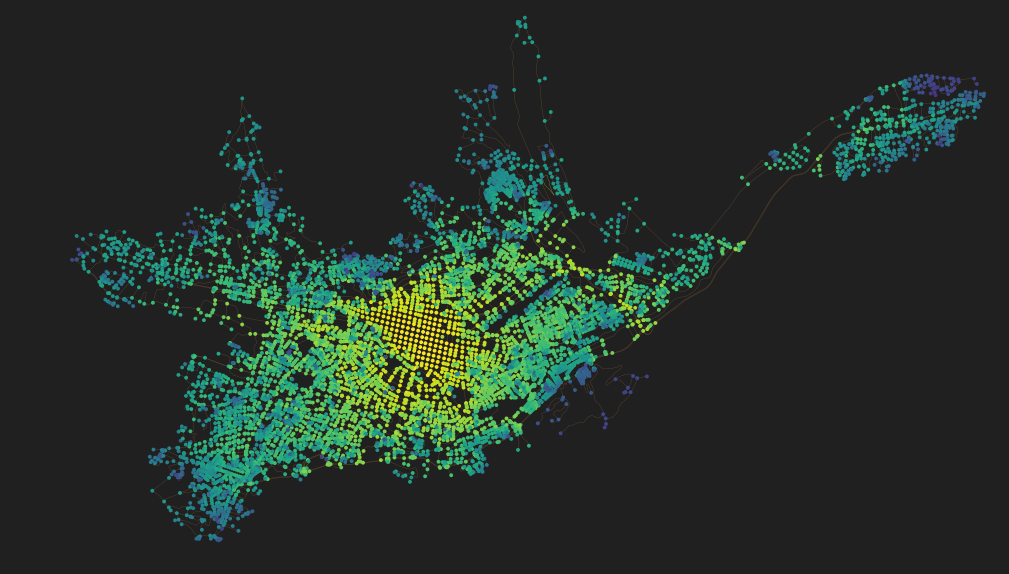

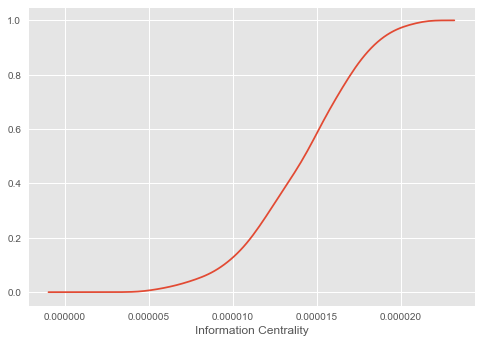

In [227]:
G = ms.network_stats(street_network, 1)
ox.save_graph_shapefile(G, folder = graphs_folder, filename = '{}/shapefile'.format('street_stats'))

## Create Bus Network Graph

plotting results for each line:


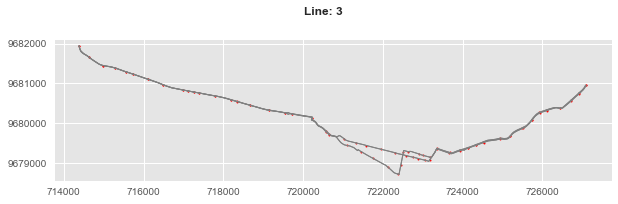

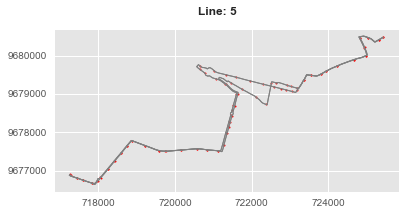

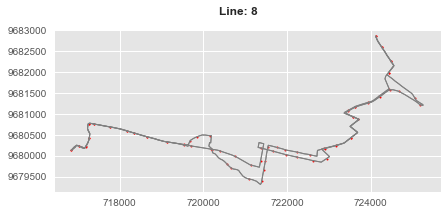

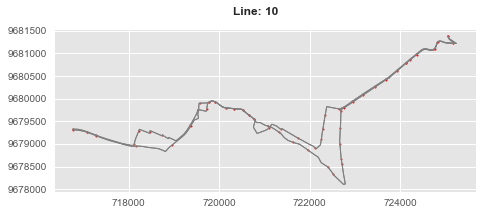

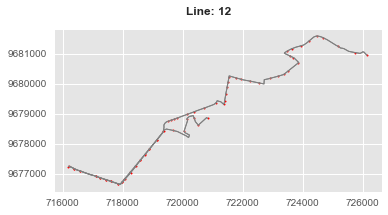

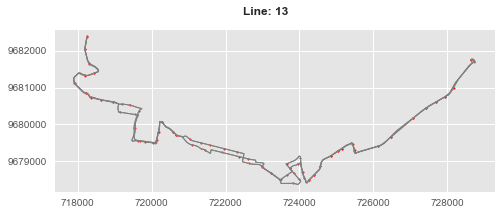

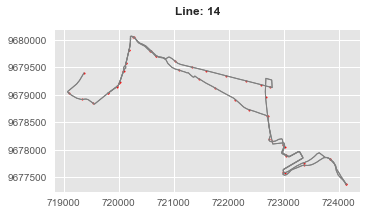

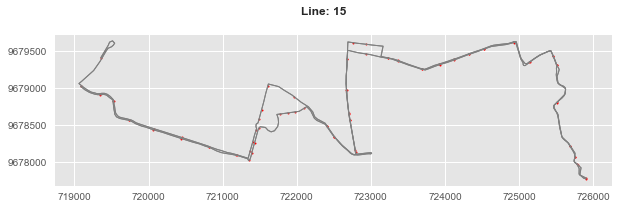

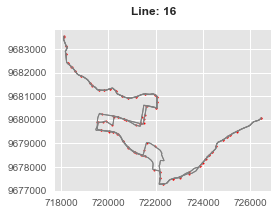

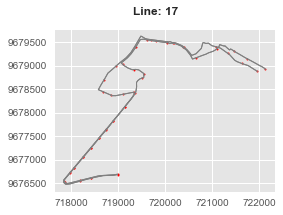

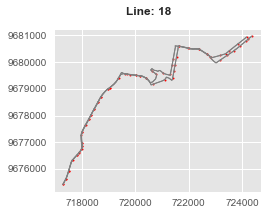

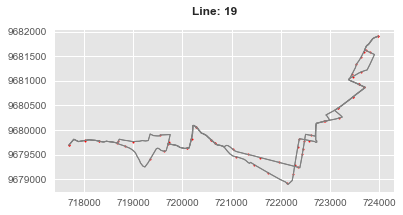

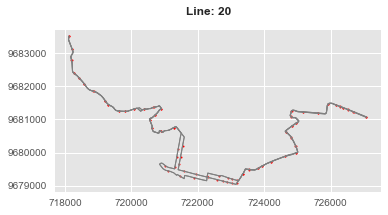

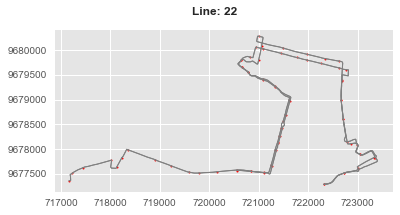

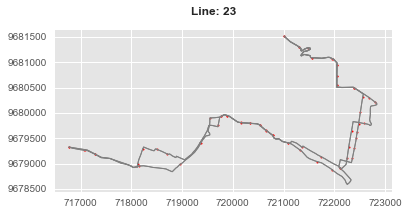

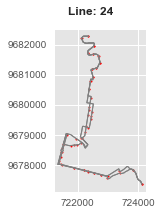

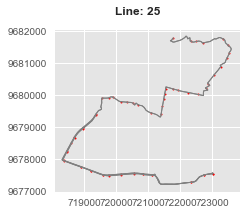

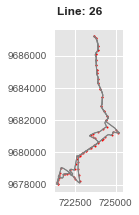

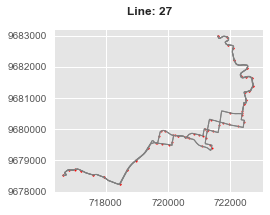

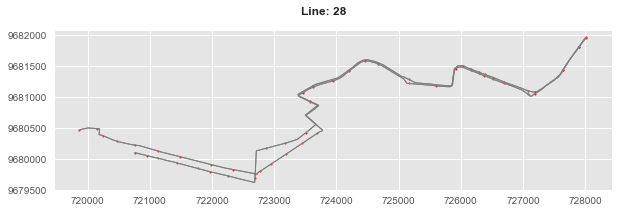

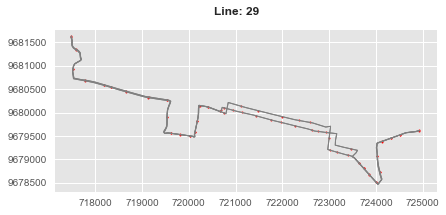

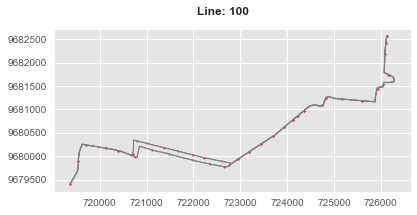

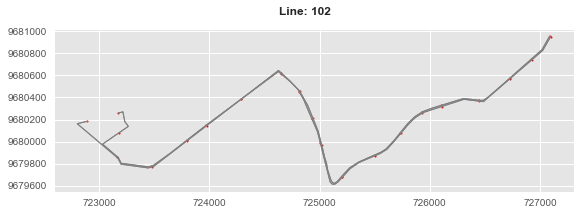

networkx.classes.multidigraph.MultiDiGraph

In [6]:
#create bus network
bus_network = ms.create_bus_network(busLineGPD, busStopGPD, area, speed = 30)
type(bus_network)
#plot bus network graph
# ox.save_graph_shapefile(bus_network, folder = graphs_folder, filename = '{}/shapefile'.format('bus_network'))
# ox.save_graphml(bus_network, folder = graphs_folder, filename = '{}/graph'.format('bus_network'))

In [8]:
ms.plot_network(bus_network, area)

[autoreload of multiplex_segregation failed: Traceback (most recent call last):
  File "C:\Anaconda\lib\site-packages\IPython\extensions\autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\Mateo Neira\Desktop\MscSMARTCITIES\dissertation\Scripts\multiplex_segregation.py", line 1238
    p = generate a ran
                 ^
SyntaxError: invalid syntax
]


## Get Bus Network Stats

calculating shortest path betweenness...
calculating random walk betweenness...
calculating reaching centrality...
calculating information centrality...
generating plots...
calculating measures for: Betweenness Centrality


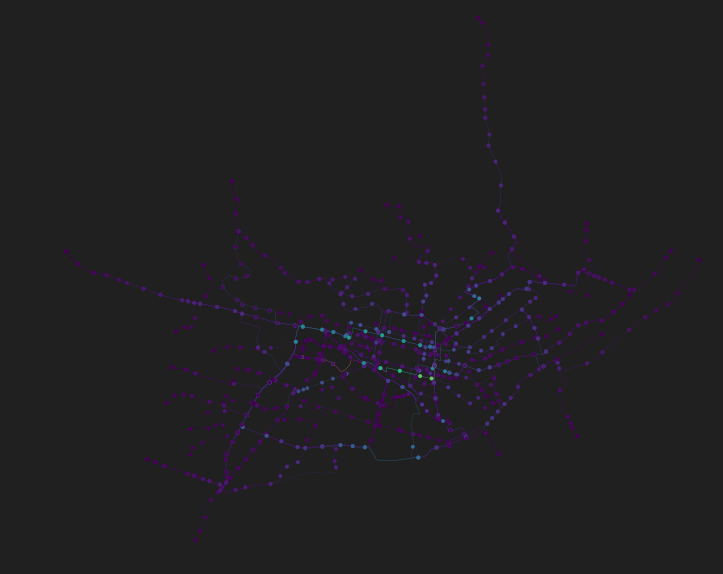

calculating measures for: Random Walk Betweenness


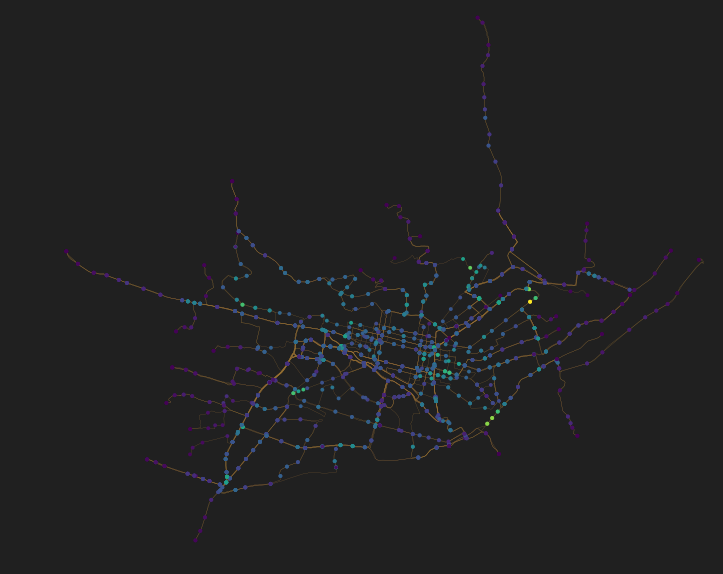

calculating measures for: Information Centrality


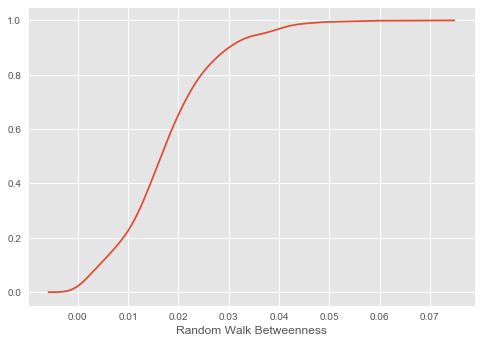

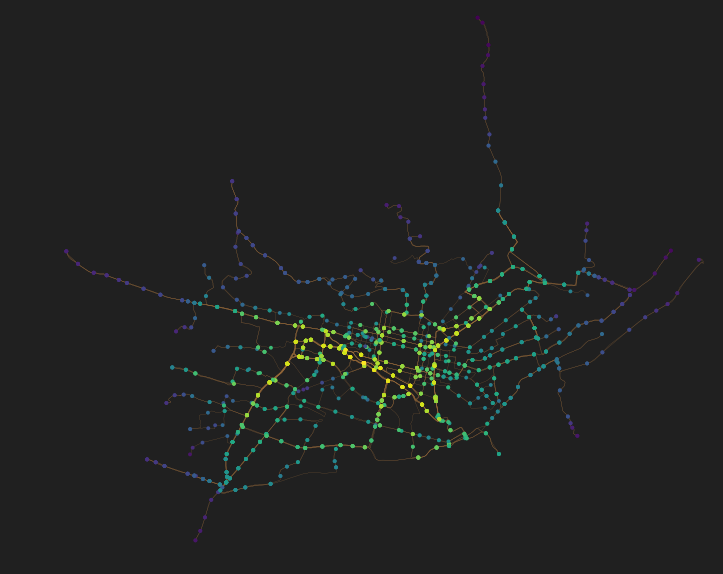

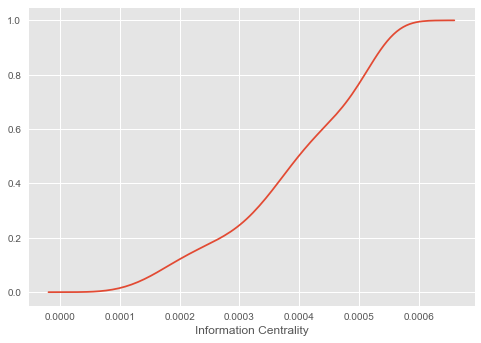

In [226]:
G = ms.network_stats(bus_network, 1)
ox.save_graph_shapefile(G, folder = graphs_folder, filename = '{}/shapefile'.format('bus_stats'))

## Create Tram Network Graph

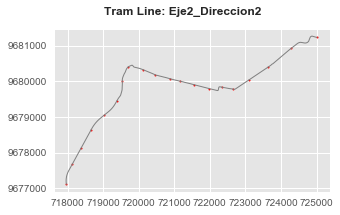

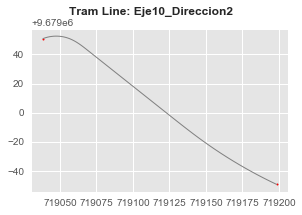

In [7]:
tram_network = ms.create_tram_network(tramLineGPD, tramStopGPD, area)
#plot bus network graph
# ox.save_graph_shapefile(tram_network, folder = graphs_folder, filename = '{}/shapefile'.format('tram_network'))
# ox.save_graphml(tram_network, folder = graphs_folder, filename = '{}/graph'.format('tram_network'))

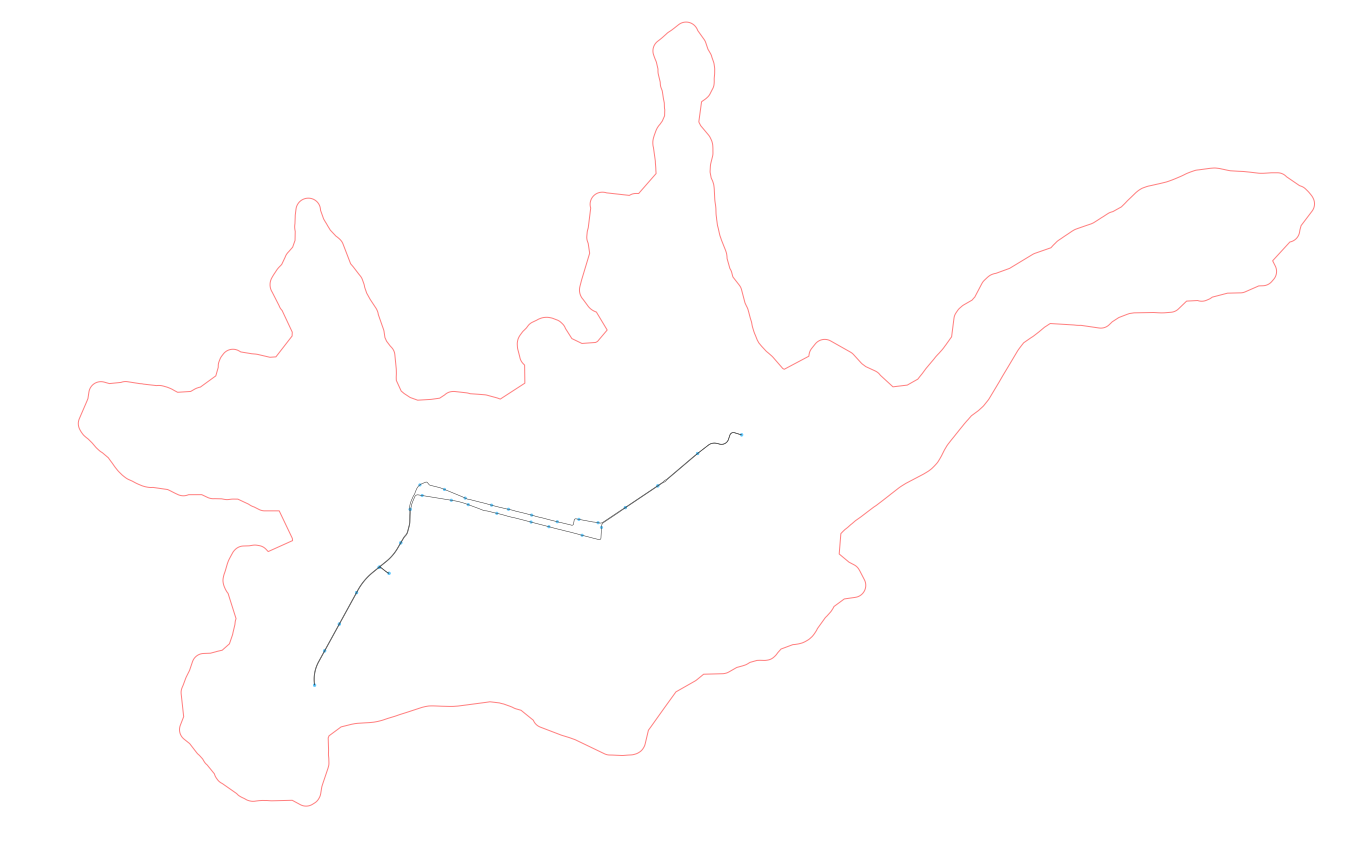

In [10]:
ms.plot_network(tram_network, area)

## Get Tram Network Stats

calculating shortest path betweenness...
calculating random walk betweenness...
calculating reaching centrality...
calculating information centrality...
generating plots...
calculating measures for: Betweenness Centrality


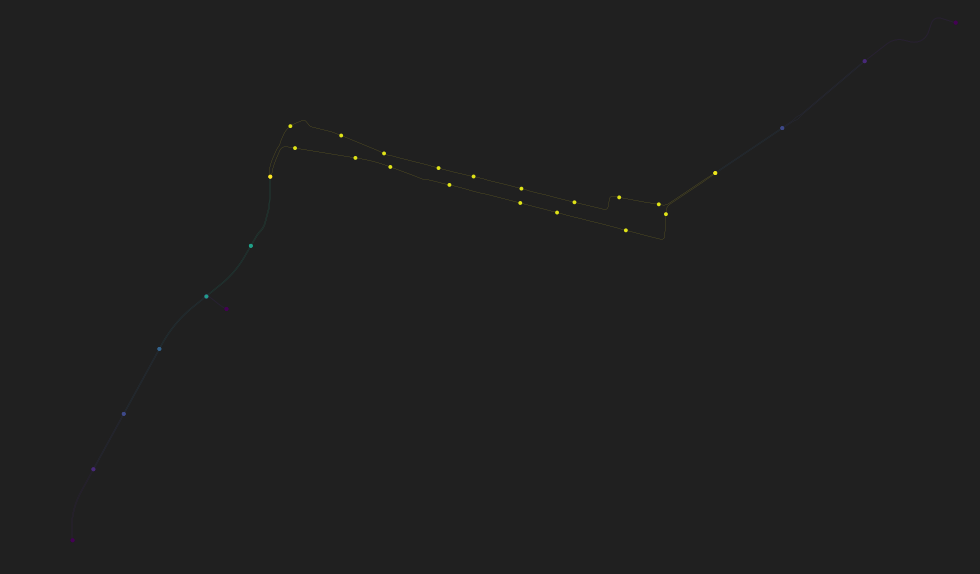

calculating measures for: Random Walk Betweenness


calculating measures for: Information Centrality


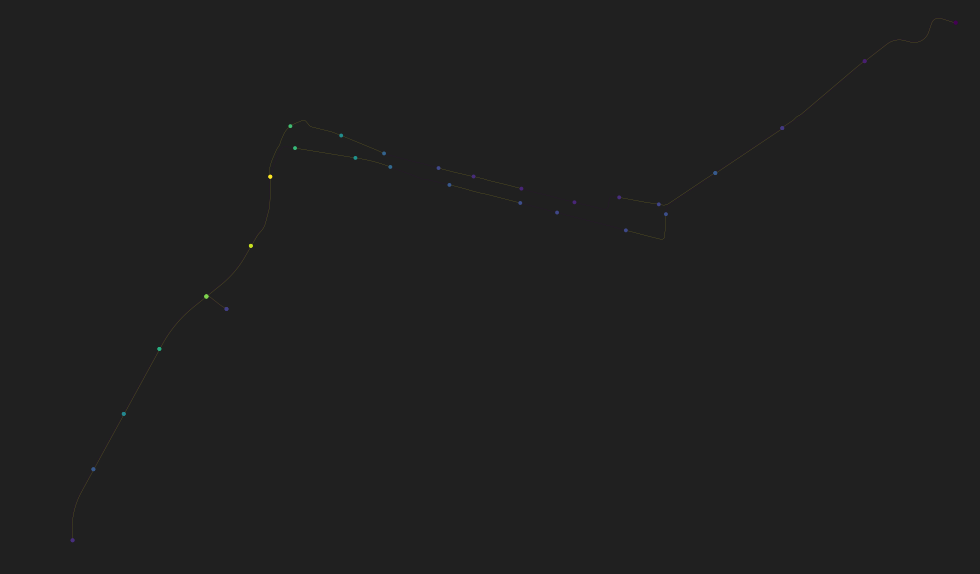

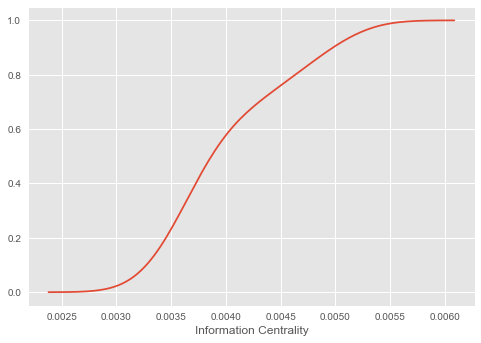

In [225]:
G = ms.network_stats(tram_network, 1)
ox.save_graph_shapefile(G, folder = graphs_folder, filename = '{}/shapefile'.format('tram_stats'))

## Assign Socio Economic Data to Nodes

voronoi tesselation and weighted area overlay interpolation is used to determine population data at each intersection.

In [21]:
#join ICV dataframe to block geometry
blocksICV = blocksGPD.merge(icvIndexDf, left_on = 'DPA_MANZAN', right_on = 'id_man')

#only conserve valid geometries with values
blocksICV = blocksICV[blocksICV.is_valid]
blocksICV = blocksICV.dropna()
blocksICV.to_file('{}/blocksICV'.format(output_path))

Ring Self-intersection at or near point 720396.05939999968 9681490.2802000009


Generating voronoi tesselation...


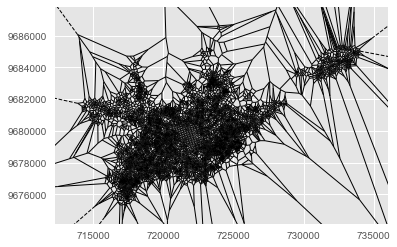

Generating geodataframe...


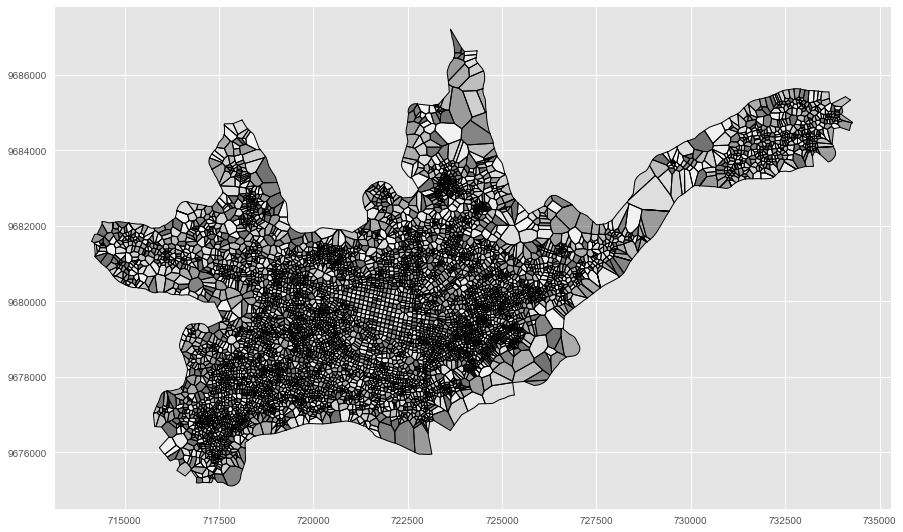

Calculating area overlay...
Calculating values for polygon...
Appending values to geometry...
done!


In [102]:
#map data to intersection
street_network = ms.blocks_to_nodes(street_network, 
                                   blocksICV, 
                                   area, 
                                   crs_utm)
#save to shapefile and graphml
# ox.save_graph_shapefile(street_network, folder = graphs_folder, filename = '{}/shapefileICV'.format('street_network'))

## Create Multiplex

In [103]:
multiplex_sb = ms.create_multiplex(street_network, [bus_network], [10])
multiplex_sbt = ms.create_multiplex(street_network, [bus_network, tram_network], [10,5])

In [16]:
ox.save_graph_shapefile(multiplex_sbt, folder = graphs_folder, filename = '{}/shapefile'.format('multiplex'))
ox.save_graphml(multiplex_sbt, folder = graphs_folder, filename = '{}/graph'.format('multiplex'))

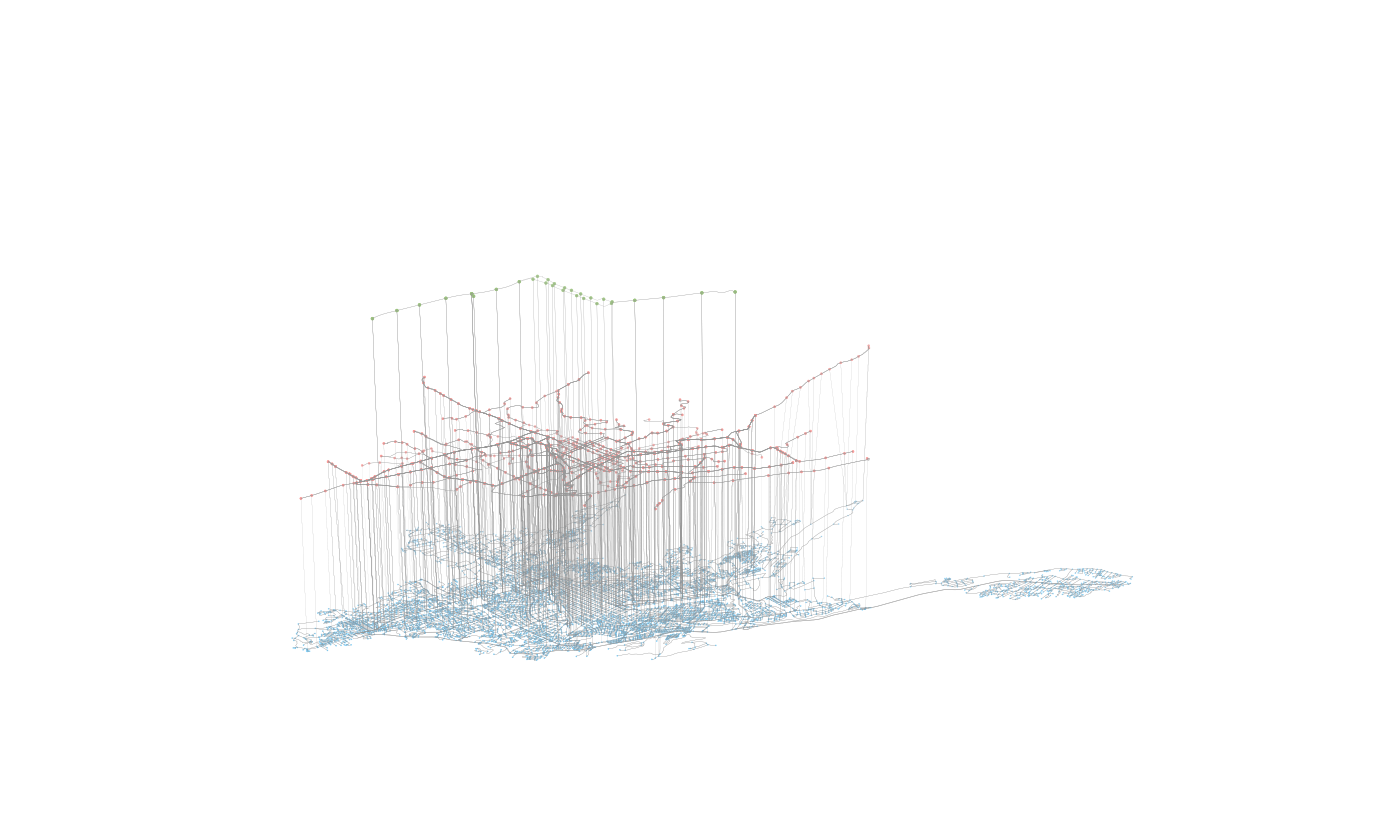

In [16]:
ms.plot_multiplex(multiplex_sbt, save = True)

## Get multiplex stats

In [104]:
node_ori = [u for u in street_network.nodes(data=False)]
node_new = ['{}-{}'.format(u, list(street_network.name)[0]) for u in node_ori]
node_dict= dict(zip(node_ori, node_new))
street_network = nx.relabel_nodes(street_network, node_dict)

In [126]:
#get betweeness
print('calculating street network')
s_bet = nx.edge_betweenness_centrality(street_network, weight = 'weight')
print('calculating sb network')
sb_bet = nx.edge_betweenness_centrality(multiplex_sb, weight = 'weight')
print('calculating sbt network')
sbt_bet = nx.edge_betweenness_centrality(multiplex_sbt, weight = 'weight')

calculating street network
calculating sb network
calculating sbt network


In [147]:
# G.copy = multiplex_sb
# measure = [sb_bet]
# ev = []
# keys = []
# if len(measure[0]) != 0:
#     for (u,v,k) in G.edges(keys=True):
#         keys.append((u,v,k))
#         if (u,v,k) in measure[0].keys():
#             ev.append(measure[0][(u,v,k)])
#         elif (u,v) in measure[0].keys():
#             ev.append(measure[0][(u,v)])
#         elif (u,v,k) in measure[0].keys():
#             ev.append(measure[0][(v,u,k)])
#         else:
#             ev.append(-1)
# else:
#     for (u,v,k) in measure[2].edges(keys=True):
#         keys.append((u,v,k))
#         ev.append(0)

# evdict_sb = dict(zip(keys, ev))
# evdict_sb
list(multiplex_sbt.nodes(data=True))[0]

('321418404-s',
 {'ICV': 0.83807243438691947,
  'Q1': 0.21400560997949067,
  'Q2': 0.24693739078345803,
  'Q3': 0.30997760302246297,
  'Q4': 0.22907939621458828,
  'betweenness': 0.00041877213326280366,
  'geometry': <shapely.geometry.point.Point at 0x2ae65c32320>,
  'highway': nan,
  'lat': -2.9061519,
  'lon': -79.0280619,
  'nDwellings': 21.673551840964858,
  'nPeople': 78.030330256505849,
  'network_type': 'street',
  'osmid': '321418404',
  'x': 719190.36779541033,
  'y': 9678588.837471094,
  'z': 0})

In [148]:
nx.set_edge_attributes(street_network, 'betweenness', evdict_s)
nx.set_edge_attributes(multiplex_sb, 'betweenness', evdict_sb)
nx.set_edge_attributes(multiplex_sbt, 'betweenness', evdict_sbt)

## Random Walk Segregation Index

In [232]:
G=multiplex_sb.copy()
alpha=0.85
# create 0 values for nodes without values
groups = ['Q1','Q2', 'Q3', 'Q4']
for group in groups:
    for i, data in G.nodes(data=True):
        if 'nPeople' not in data.keys():
            G.node[i]['nPeople'] = 0
        if group not in data.keys():
            G.node[i][group] = 0


    ##get the values we need
    n_i = np.array(list(nx.get_node_attributes(G, 'nPeople').values()))
    n = n_i.sum()

    c_gi = np.array(list(nx.get_node_attributes(G,group).values()))
    n_gi = c_gi * n_i
    n_g = n_gi.sum()
    d_gi = n_gi / n_g

    c_gi.shape = (len(c_gi),1)
    d_gi.shape = (len(d_gi),1)

    W = nx.adjacency_matrix(G, weight='betweenness')
    Degree = sp.sparse.spdiags(1./W.sum(1).T, 0, *W.shape)
    I = sp.identity(len(G))
    P = Degree * W
    Q = (1-alpha) * (I - alpha * P).I * P

    isolation_gi = np.multiply(d_gi,(Q*c_gi))

    norm_isolation_gi = (n_g/n)**-1 * isolation_gi * len(isolation_gi)
    print('norm seg for group {} = {}'.format(group,norm_isolation_gi.mean()))
    sigma_bar = list(np.array(norm_isolation_gi.flatten())[0])
    res = dict(zip(list(G.nodes()), sigma_bar))
    nx.set_node_attributes(G, 'sigma-{}'.format(group), res)

norm seg for group Q1 = 0.9339157274604976
norm seg for group Q2 = 0.7232552821095097
norm seg for group Q3 = 0.7351173244889592
norm seg for group Q4 = 0.9734287168192963


In [231]:
ox.save_graph_shapefile(G, folder = graphs_folder, filename = '{}/shapefile'.format('multi_sbt_seg'))

In [120]:
list(street_network.nodes(data=True))[10]

('1368603176-s',
 {'ICV': 0.86997232545718306,
  'Q1': 0.26818199818586602,
  'Q2': 0.26517242257288159,
  'Q3': 0.40140096900091465,
  'Q4': 0.065244610240338091,
  'betweenness': 0.012452111020299675,
  'geometry': <shapely.geometry.point.Point at 0x2ae1e0588d0>,
  'highway': nan,
  'lat': -2.9058321,
  'lon': -79.0329317,
  'nDwellings': 7.0047568805728959,
  'nPeople': 24.325022224677827,
  'network_type': 'street',
  'osmid': '1368603176',
  'x': 718648.91442614782,
  'y': 9678625.1508900132,
  'z': 0})

In [47]:
G= multiplex.copy()
t=20
import time
full_start_time = time.time()
nodes = list(G.nodes())
#get only street nodes
street_nodes = ([s for s in nodes if 's' in s])
soi = []
for i in street_nodes:
    print('starting calculation for node {}'.format(i))
    start_time = time.time()
    dist = []
    #get nodes within temporal constraint
    G_i = nx.ego_graph(G, i, radius = t, center=True, distance = 'weight')
    ssdpl = list(dict(nx.single_source_dijkstra_path_length(G_i, i, weight='length')).values())
    avg_ssdpl = np.array(ssdpl[1:len(ssdpl)]).sum() / len(ssdpl[1:len(ssdpl)])
    print('calculated spatial outreach for node: {} in {:.2f} seconds'.format(i,time.time() - start_time))

spatial_outreach_dict = dict(zip(nodes, soi))
print('calculated spatial outreach for graph in {:.2f} seconds'.format(time.time() - full_start_time))

starting calculation for node 321418404-s
568.477772772
calculated spatial outreach for node: 321418404-s in 0.33 seconds
starting calculation for node 321418405-s
565.394452015
calculated spatial outreach for node: 321418405-s in 0.33 seconds
starting calculation for node 611406050-s
686.87089876
calculated spatial outreach for node: 611406050-s in 0.33 seconds
starting calculation for node 611406047-s
503.151670105
calculated spatial outreach for node: 611406047-s in 0.35 seconds
starting calculation for node 1725895464-s
708.320245683
calculated spatial outreach for node: 1725895464-s in 0.32 seconds
starting calculation for node 321418410-s
315.859129867
calculated spatial outreach for node: 321418410-s in 1.27 seconds
starting calculation for node 611406058-s
435.521359613
calculated spatial outreach for node: 611406058-s in 0.57 seconds
starting calculation for node 1725895450-s
413.484096092
calculated spatial outreach for node: 1725895450-s in 0.52 seconds
starting calculation 

KeyboardInterrupt: 

In [113]:
t=20
G = multiplex_sbt.copy()
i = '525278480-s'
#get nodes within temporal constraint
G_i = nx.ego_graph(G, i, radius = t, center=True, distance = 'weight')
print('got subset graph')
ssdpl = list(dict(nx.single_source_dijkstra_path_length(G_i, i, weight='length')).values())
print('calculated dijkstra')
avg_ssdpl = np.array(ssdpl[1:len(ssdpl)]).sum() / len(ssdpl[1:len(ssdpl)])
max_ssdpl = max(ssdpl[1:len(ssdpl)])

ms.plot_network(G_i, area)

got subset graph
calculated dijkstra


In [71]:
temp =dict(nx.single_source_dijkstra_path_length(G_i, i, weight='length'))

In [84]:
G_temp = G.subgraph(list(G_i.nodes()))
# max(temp)
# temp['999956784-s']
max_key = max(temp, key=lambda k: temp[k])
max_key
temp['4059177185-s']

861.79866408864484

In [135]:
nodes = nx.get_node_attributes(G_i,'geometry')
ori_point = nodes[i]
nodes.pop(i)
dest_points = [nodes[k] for k in nodes.keys()]
dist = np.array([ori_point.distance(dest) for dest in dest_points])
max(dist)
# ms.plot_network(G_temp, area)
# temp =dict(nx.single_source_dijkstra_path_length(G_temp, i, weight='length'))
# max_key = max(temp, key=lambda k: temp[k])
# max_key
# temp['4059177185-s']

4749.3095415542884

In [111]:
nx.get_node_attributes(G_i,'geometry')
nx.number_weakly_connected_components(G_temp)

14

In [192]:
for u,v,k in G.edges(keys=True):
    print (u,v,k)

0 24 0
1 0 18
1 25 0
2 1 17
2 26 0
3 2 16
3 27 0
4 3 15
4 21 0
4 23 0
4 28 0
5 4 14
5 29 0
6 15 7
7 11 10
8 17 3
8 33 0
9 12 1
9 34 0
10 9 0
10 35 0
11 13 11
12 8 2
12 36 0
13 14 12
14 5 13
14 38 0
15 16 8
16 7 9
17 19 4
18 6 6
19 18 5
20 21 19
20 22 0
21 4 0
21 23 0
21 28 0
22 20 0
23 22 20
23 4 0
23 21 0
23 28 0
24 25 21
24 0 0
25 26 22
25 1 0
26 27 23
26 2 0
27 28 24
27 3 0
28 29 25
28 4 0
28 21 0
28 23 0
29 38 26
29 5 0
30 40 34
31 32 28
32 39 29
33 36 36
33 8 0
34 35 38
34 9 0
35 10 0
36 34 37
36 12 0
37 42 31
38 31 27
38 14 0
39 37 30
40 33 35
41 30 33
42 41 32


In [137]:
dist.sum()/len(dist)

1878.6254957694066